<a href="https://colab.research.google.com/github/mmartamagna/Machine-Learning-Project-CatsDogs/blob/main/Project_CatsDogs_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary classification with Neural Networks
### *Marta Magnani (961071) - Università degli Studi di Milano*

Project for the course **Statistical methods for Machine Learning** for the academic year 2021-2022. The task is to implement a neural network for the binary classification of cats and dogs images.

Data source: https://unimibox.unimi.it/index.php/s/eNGYGSYmqynNMqF

***Attention:*** if you want to directly run the CNN models, I suggest you to download or connect to the shared folder named Pickles (https://drive.google.com/drive/folders/1rCcfqym_UIUSDBr2_uOUBwt-f7FUr7y7?usp=sharing)  and use the following files (images_grey.pickle, labels_grey.pickle). Then skip to the section entitled "Normalizing pixel values" to open these files and proceed with the training of CNNs.

###**Packages**

In [ ]:
import pandas as pd #reading/writing data
import numpy as np #working with arrays, linear algebra
import matplotlib.pyplot as plt #display images
import matplotlib.image as mpimg
import os
from os import listdir
import seaborn as sns
import random
import pickle

#Image preprocessing
import pathlib
import PIL
import PIL.Image
import cv2

#Neural Networks
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical, load_img, img_to_array
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, callbacks, regularizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.losses import binary_crossentropy
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

#Cross validation
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, zero_one_loss

tfk = tf.keras
#tf.keras.backend.set_floatx("float64")
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### **Data import**
Data were downloaded from Unimibox shared folder (https://unimibox.unimi.it/index.php/s/eNGYGSYmqynNMqF) to Google drive and saved in a folder named 'CatsDogs' with two subfolders ('Cats', 'Dogs') containing 12500 images each.

In [ ]:
#Open the data from Google Drive
from google.colab import drive
drive.mount('/content/drive')
dir = '/content/drive/MyDrive/Project CatsDogs/CatsDogs'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#create two variables containing the data of cats and dogs
cats_folder = os.path.join(dir, 'Cats')
dogs_folder = os.path.join(dir, 'Dogs')

## **Data preprocessing**
This section is entirely dedicated to the data preparation for the Neural Network construction. The steps are:
* Misleading images removal
* Resizing and conversion to greyscale
* Normalize pixels to 0,1

### **Misleading images removal**
Cats and Dogs folders both contain some misleading images that do not represent real animals at all (e.g. people, words, drawings, forests, etc), or that contain both cats and dogs. Removing these kind of data ensures:

- Data Quality: incorrect images can introduce confusion and mislead the training process. By removing them, we ensure that NN model focuses on learning the specific features and patterns associated with cats and dogs.
- Avoiding Bias: including unrelated images can introduce bias into training data, potentially causing the model to learn incorrect associations or generalize poorly to new data. Removing these images helps in maintaining the integrity and representativeness of dataset.
- Model Performance: removing incorrect images can improve the overall performance of the model. By training on a cleaner dataset, the model can better learn the distinguishing characteristics of cats and dogs, leading to more accurate predictions.

In [ ]:
##Define vectors containing misleading images
wrong_cats = [666, 835, 1450, 2939, 3216, 3330, 3672, 3822, 4085, 4104, 4338, 4688, 4833, 5351,
              5355, 5418, 5583, 5673, 7377, 7564, 7920, 7968, 8456, 8470, 9171, 9770, 10404,
              10712, 10863, 11184, 11565, 12272]

wrong_dogs = [7, 1043, 1194, 1259, 1308, 1773, 1895, 2614, 2877, 4367, 5490, 5604, 5694, 6272,
              6475, 7798, 8507, 8736, 8898, 9188, 9517, 10161, 10190, 10237, 10401, 11702, 10747,
              10797, 10801, 11186, 11299, 11731, 12005, 12027, 12376]

In [ ]:
#REMOVING ALL THE MISLEADING IMAGES
import shutil

# Remove misleading images from the cats folder
for cat_number in wrong_cats:
    filename = f"{cat_number}.jpg"
    file_path = os.path.join(cats_folder, filename)
    if os.path.exists(file_path):
        os.remove(file_path)

# Remove misleading images from the dogs folder
for dog_number in wrong_dogs:
    filename = f"{dog_number}.jpg"
    file_path = os.path.join(dogs_folder, filename)
    if os.path.exists(file_path):
        os.remove(file_path)

In [ ]:
# Count the remaining images in the cats folder
cats_images = [file for file in os.listdir(cats_folder) if file.endswith(".jpg")]
num_cats_images = len(cats_images)

# Count the remaining images in the dogs folder
dogs_images = [file for file in os.listdir(dogs_folder) if file.endswith(".jpg")]
num_dogs_images = len(dogs_images)

print(f"Number of remaining cat images: {num_cats_images}")
print(f"Number of remaining dog images: {num_dogs_images}")

In [ ]:
#Print a sample of cats images
plt.figure(figsize=(20,20))
for i in range(5):
    file = random.choice(os.listdir(cats_folder))
    image_path= os.path.join(cats_folder, file)
    img=mpimg.imread(image_path)
    print(img.shape)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

In [ ]:
#Print a sample of dogs images
plt.figure(figsize=(20,20))
for i in range(5):
    file = random.choice(os.listdir(dogs_folder))
    image_path= os.path.join(dogs_folder, file)
    img=mpimg.imread(image_path)
    print(img.shape)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

### **Resize and set greyscale**

In [ ]:
#Recall directory
dir = '/content/drive/MyDrive/Project CatsDogs/CatsDogs'

WIDTH = 128
HEIGHT = 128
img_size = (WIDTH, HEIGHT)

#Set channel = 1 for grey images
channels = 1

# Define the list in which the images will be stored and categories of pets
pets_grey = []
categories = ['Cats','Dogs']

# Function to load the data, transform into array of grey images, assign data to a class and store them in the pets list
def create_data_grey():

# the function iterates throught the two sub-directories
    for category in categories:
        path = os.path.join(dir, category)
        pet_class = categories.index(category) # assign 0 to cat and 1 to dog, according to the index of the categories

# the function iterates through each image in both the folders. Opencv (cv2 when imported) package allows to read and load them.
        for img in os.listdir(path):   
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, img_size)  #resize the images 128x128
                pets_grey.append([new_array, pet_class]) #appends the array of the image, together with the class value (creating a sub-list of two values for each image), to the pets list.
            except:
                pass

#Call the function
create_data_grey()

In [ ]:
# Shuffle the order of the  grey images
random.seed(256)
random.shuffle(pets_grey)

# split the data into images and labels arrays
images_array_grey = []
labels_array_grey = []


for image, label in pets_grey:
    images_array_grey.append(image)
    labels_array_grey.append(label)


images_array_grey = np.array(images_array_grey).reshape(-1, 128, 128, 1)

**Pickle** in Python is primarily used in serializing and deserializing a Python object structure. It's the process of converting a Python object into a byte stream to store it in a file/database, maintain program state across sessions, or transport data over the network. (Source: Synopsys, 2014). In summary, the code saves the X and Y arrays as pickle files using pickle.dump(), and later loads them back into memory using pickle.load() to retrieve the stored data. This allows to store and retrieve the arrays without losing their structure or data types. Other sources for the code:

* https://stackoverflow.com/questions/25104618/pickling-an-image-object.
* https://stackoverflow.com/questions/70238017/pickle-dumpmodel-pickle-out-typeerror-cant-pickle-thread-local-objects

In [ ]:
#########GREYSCALE PICKLE FILES########
#Open a file called "X.pickle" write in binary mode ('wb'). It creates a file object pickle_out that will be used to write the data.
pickle_output_grey = open('/content/drive/MyDrive/Project CatsDogs/CatsDogs/Pickles/images_grey.pickle','wb')
#pickle.dump(X_images, pickle_out) writes the content of the X array to the pickle file using the pickle.dump() function.
pickle.dump(images_array_grey, pickle_output_grey)
pickle_output_grey.close()

#Open a file called "y.pickle" write in binary mode ('wb').
pickle_output_grey = open('/content/drive/MyDrive/Project CatsDogs/CatsDogs/Pickles/labels_grey.pickle','wb')
#pickle.dump(Y, pickle_out) writes the content of the Y array to the pickle file using the pickle.dump() function.
pickle.dump(labels_array_grey, pickle_output_grey)
pickle_output_grey.close()

#Open a file called "X.pickle" and read in binary mode ('wb').
pickle_input_grey = open('/content/drive/MyDrive/Project CatsDogs/CatsDogs/Pickles/images_grey.pickle','rb')
images_array_grey = pickle.load(pickle_input_grey)

#Open a file called "Y.pickle" and write in binary mode ('wb').
pickle_input_grey = open('/content/drive/MyDrive/Project CatsDogs/CatsDogs/Pickles/labels_grey.pickle','rb')
labels_array_grey = pickle.load(pickle_input_grey)

In [ ]:
#Load the data in pickle format
images_array_grey = pickle.load(open('/content/drive/MyDrive/Project CatsDogs/CatsDogs/Pickles/images_grey.pickle','rb'))
labels_array_grey = pickle.load(open('/content/drive/MyDrive/Project CatsDogs/CatsDogs/Pickles/labels_grey.pickle','rb'))

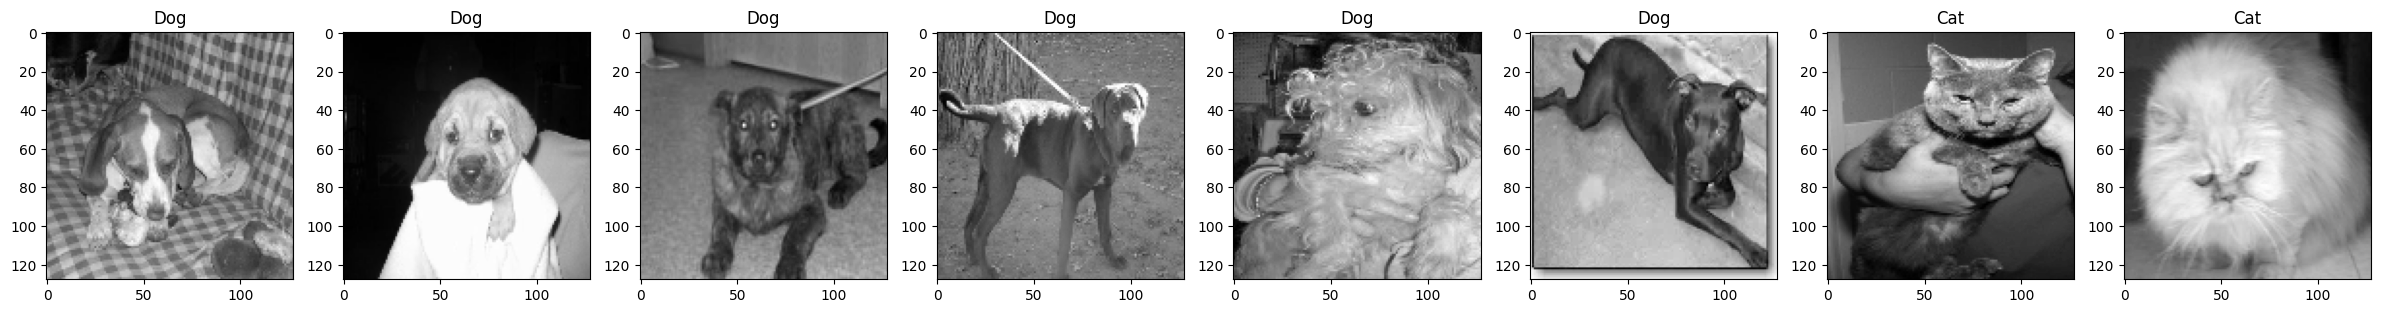

In [ ]:
#see a sample of images in greyscale
class_labels = ['Cat','Dog']
#Plot some images
images_to_plot = 8
grey_channel = 0

f, ax = plt.subplots(1, images_to_plot)
f.set_size_inches(30, 20)

for i in range(images_to_plot):
  grey_image = images_array_grey[i][:, :, grey_channel]
  ax[i].imshow(grey_image, cmap = "gray")
  numeric_label = labels_array_grey[i]
  ax[i].set_title(class_labels[numeric_label])

***Attention!!***

If you want to avoid the processing pahses above, you can directly download the pickles file from my GitHub profile (respectively named images_grey.pickle, labels_grey.pickle.pickle) and remember to change the path of the directory when opening them. Once downloaded, you can proceed with the normalization of pixel values and the construction of CNN models.

###**Normalizing pixel vaues**
- We need to rescale the value contained in each pixel for all images in our training and test sets, so that the range of possible pixel values changes from integers in  [0,255] to standardized values in [0,1].

In [ ]:
# Load grey images and labels from pickle files
with open('/content/drive/MyDrive/Project CatsDogs/CatsDogs/Pickles/images_grey.pickle','rb') as f:
    images_grey = pickle.load(f)
with open('/content/drive/MyDrive/Project CatsDogs/CatsDogs/Pickles/labels_grey.pickle','rb') as f:
    labels_grey = pickle.load(f)

# Normalize pixel values (0-255) to be between 0 and 1
images_grey = np.array(images_grey) / 255.0

# Make also labels a numpy array
images_grey = np.array(images_grey)
labels_grey = np.array(labels_grey)

##**Convolutional Neural Networks models definition**

###**Model 1**
---------------------------------------

In [ ]:
#MULTILAYERED MODEL FOR GREY IMAGES (IN THE FIRST CONV LAYER I SET 1 FOR GREY IMAGES)
model1 = models.Sequential()

# First convolutional layer
model1.add(layers.Conv2D(32, (3,3), activation="relu", input_shape=(128, 128, 1)))
model1.add(layers.MaxPooling2D((2,2)))
model1.add(layers.Dropout(0.25))

# Second convolutional layer
model1.add(layers.Conv2D(64, (3,3), activation="relu"))
model1.add(layers.MaxPooling2D((2,2)))
model1.add(layers.Dropout(0.25))

# Third convolutional layer
model1.add(layers.Conv2D(128, (3,3), activation="relu"))
model1.add(layers.MaxPooling2D((2,2)))
model1.add(layers.Dropout(0.25))

# Flattening the tensor output from the convolutional layers
model1.add(layers.Flatten())

# Dense layer
model1.add(layers.Dense(128, activation="relu"))
model1.add(layers.Dropout(0.5))

# Output layer
model1.add(layers.Dense(1, activation="sigmoid"))

model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 30, 30, 64)        0

In [ ]:
tf.keras.utils.plot_model(
    model1,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

### **Model 2**

In [ ]:
# MODEL 2 FOR GREYIMAGES, I SET 1 AS CHANNEL IN THE FIRST CONVOLUTIONAL LAYER
model2 = models.Sequential()

# First convolutional layer
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Dropout(0.25))

# Second convolutional layer
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Dropout(0.25))

# Third convolutional layer
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Dropout(0.25))

# Flattening the tensor output from the convolutional layers
model2.add(layers.Flatten())

# Dense layer
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.BatchNormalization())
model2.add(layers.Dropout(0.5))

# Output layer
model2.add(layers.Dense(1, activation='sigmoid'))

model2.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 126, 126, 32)      320       
                                                                 
 batch_normalization_20 (Bat  (None, 126, 126, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 dropout_48 (Dropout)        (None, 63, 63, 32)        0         
                                                                 
 conv2d_37 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_21 (Bat  (None, 61, 61, 64)     

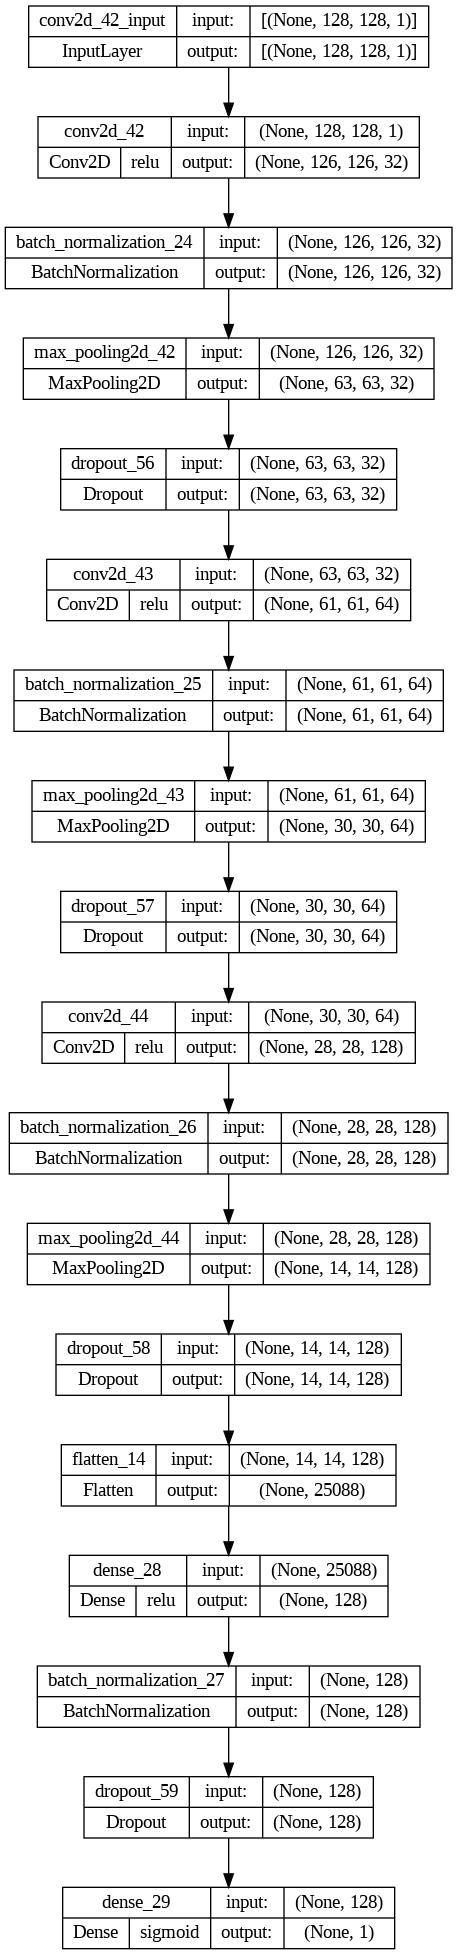

In [ ]:
tf.keras.utils.plot_model(
    model2,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

###**5-fold Cross Validation**
5-fold cross-validation is a statistical method to estimate the performance of a machine learning model with a limited data sample. The goal of cross-validation is to test the model's ability to predict new data that were not used in estimating it, in order to flag problems like overfitting or selection bias and to give an insight on how the model will generalize to an independent dataset.

Here's how 5-fold cross-validation works:
* Shuffle the dataset randomly.
* Split the dataset into 5 groups or "folds".
* For each unique group:
* Take the group as a test data set.
* Take the remaining groups as a training data set.
* Fit a model on the training set and evaluate it on the test set.
* Retain the evaluation score and discard the model.


###**Setting hyperparameters**

- **Optimizer**: *Adam (Adaptive Moment Estimation)* is a popular optimizer that combines the advantages of both AdaGrad and RMSProp algorithms. It adapts the learning rate dynamically for each parameter based on past gradients and squared gradients. Adam is known for its good performance on a wide range of problems.
- **Batch size**: 64.
- **Epochs**: 30
- **Metrics**: Binary accuracy
- **Loss function**: Binary cross-entropy

### **Model 1 Greyscale**

156/156 [==============================] - 1s 5ms/step
Fold 1: Accuracy: 0.8622213295842539, Zero-One Loss: 0.1377786704157461, Binary Cross Entropy Loss: 0.21278699363271394


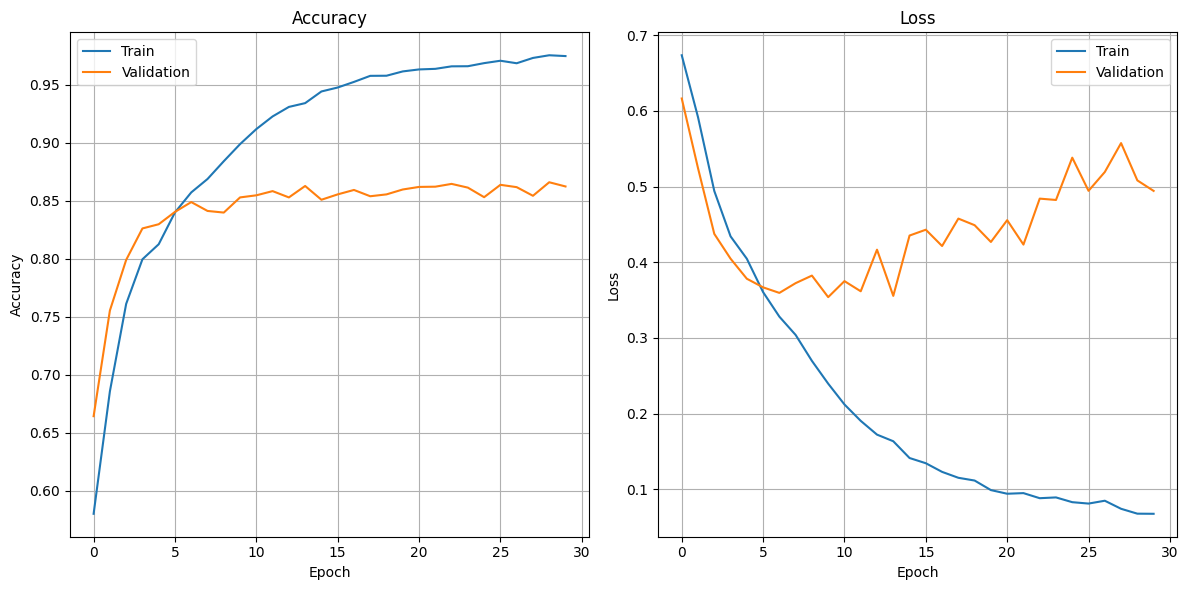

156/156 [==============================] - 1s 4ms/step
Fold 2: Accuracy: 0.8626230166700141, Zero-One Loss: 0.13737698332998594, Binary Cross Entropy Loss: 0.24054414108395578


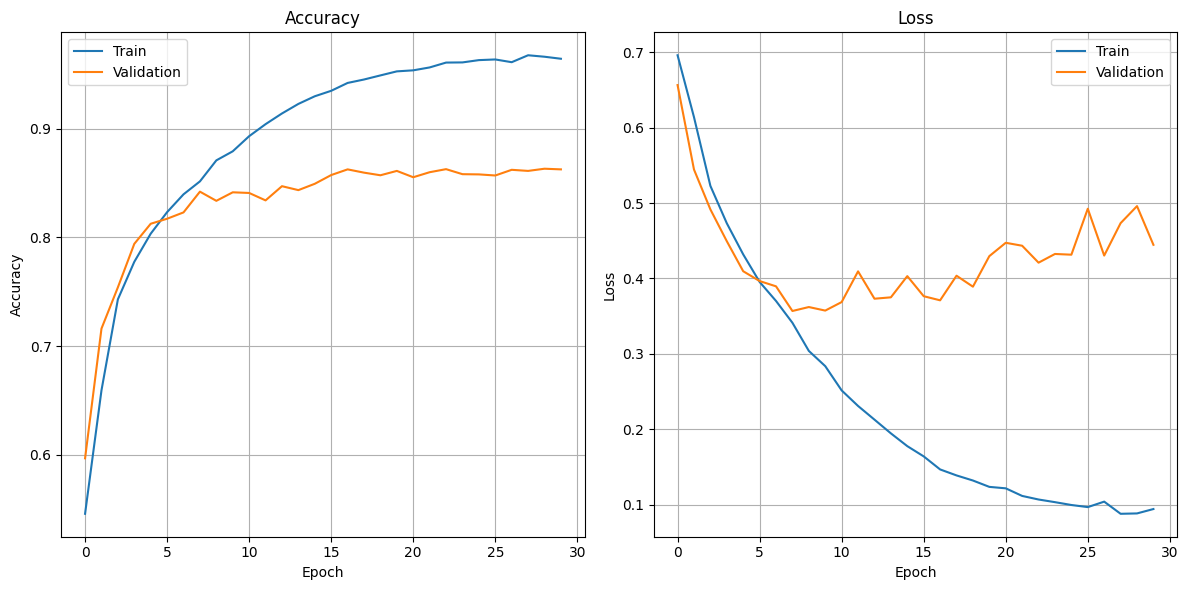

156/156 [==============================] - 1s 4ms/step
Fold 3: Accuracy: 0.8413336011247239, Zero-One Loss: 0.15866639887527612, Binary Cross Entropy Loss: 0.22164647355675698


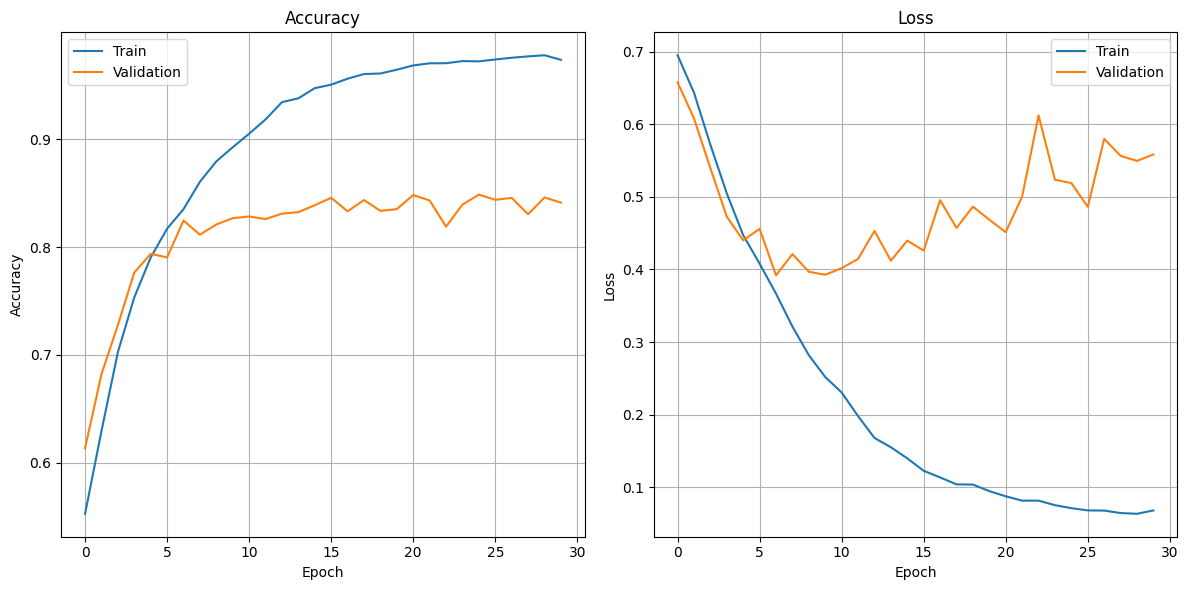

156/156 [==============================] - 1s 4ms/step
Fold 4: Accuracy: 0.8596103635268126, Zero-One Loss: 0.14038963647318736, Binary Cross Entropy Loss: 0.23192064041892688


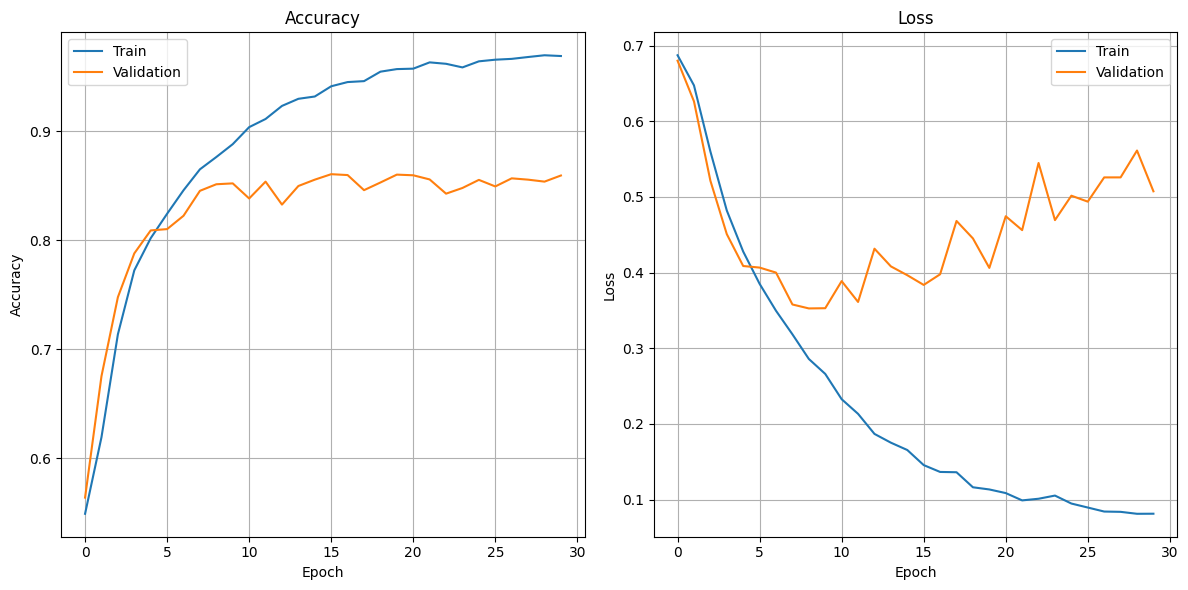

156/156 [==============================] - 1s 4ms/step
Fold 5: Accuracy: 0.8489656557541675, Zero-One Loss: 0.1510343442458325, Binary Cross Entropy Loss: 0.20723023613293964


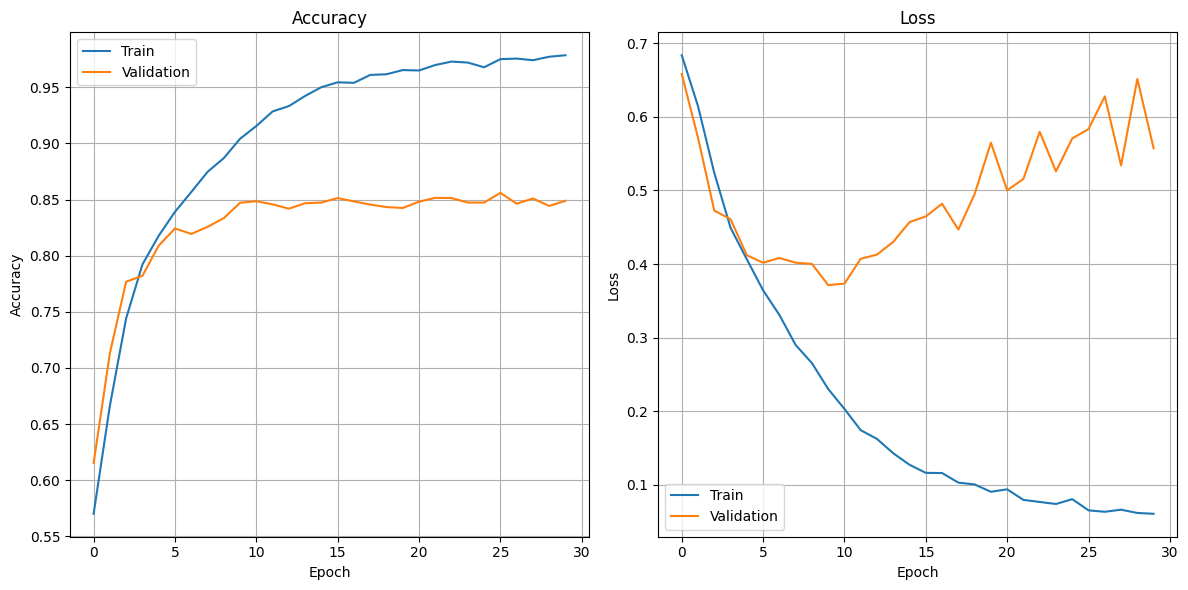

Average Accuracy: 0.8549507933319944
Average Zero-One Loss: 0.1450492066680056
Average Binary Cross Entropy Loss: 0.22282569696505866


In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
import numpy as np

def create_model():
    model = Sequential()
    # First convolutional layer
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    # Second convolutional layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    # Third convolutional layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    # Flattening the tensor output from the convolutional layers
    model.add(Flatten())
    # Dense layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    return model

# Initialize 5-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True)

# Lists to store the scores, zero-one loss, and binary cross entropy loss for each fold
scores_per_fold = []
zero_one_losses = []
binary_cross_entropy_losses = []

# Perform 5-fold CV, print results, and calculate metrics for each fold
for fold, (train_index, test_index) in enumerate(kfold.split(images_grey, labels_grey)):
    # Split data into training and test set
    train_images, test_images = images_grey[train_index], images_grey[test_index]
    train_labels, test_labels = labels_grey[train_index], labels_grey[test_index]

    model = create_model()

    # Train the model
    history = model.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=30, batch_size=64, verbose=0)

    # Use the model to make predictions on the test set
    predictions = model.predict(test_images)
    predictions = np.round(predictions).flatten()

    # Compute accuracy and zero-one loss
    score = accuracy_score(test_labels, predictions)
    zero_one_loss = 1 - score

    scores_per_fold.append(score)
    zero_one_losses.append(zero_one_loss)
    binary_cross_entropy_loss = np.mean(history.history['loss'])
    binary_cross_entropy_losses.append(binary_cross_entropy_loss)

    print(f"Fold {fold+1}: Accuracy: {score}, Zero-One Loss: {zero_one_loss}, Binary Cross Entropy Loss: {binary_cross_entropy_loss}")

    # Plot accuracy and loss for current fold
    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Compute the average scores
avg_score = np.mean(scores_per_fold)
avg_zero_one_loss = np.mean(zero_one_losses)
avg_binary_cross_entropy_loss = np.mean(binary_cross_entropy_losses)

print(f"Average Accuracy: {avg_score}")
print(f"Average Zero-One Loss: {avg_zero_one_loss}")
print(f"Average Binary Cross Entropy Loss: {avg_binary_cross_entropy_loss}")

### **Model 2 Greyscale**

156/156 [==============================] - 1s 5ms/step
Fold 1: Accuracy: 0.8732677244426592, Zero-One Loss: 0.1267322755573408, Binary Cross Entropy Loss: 0.168801079193751


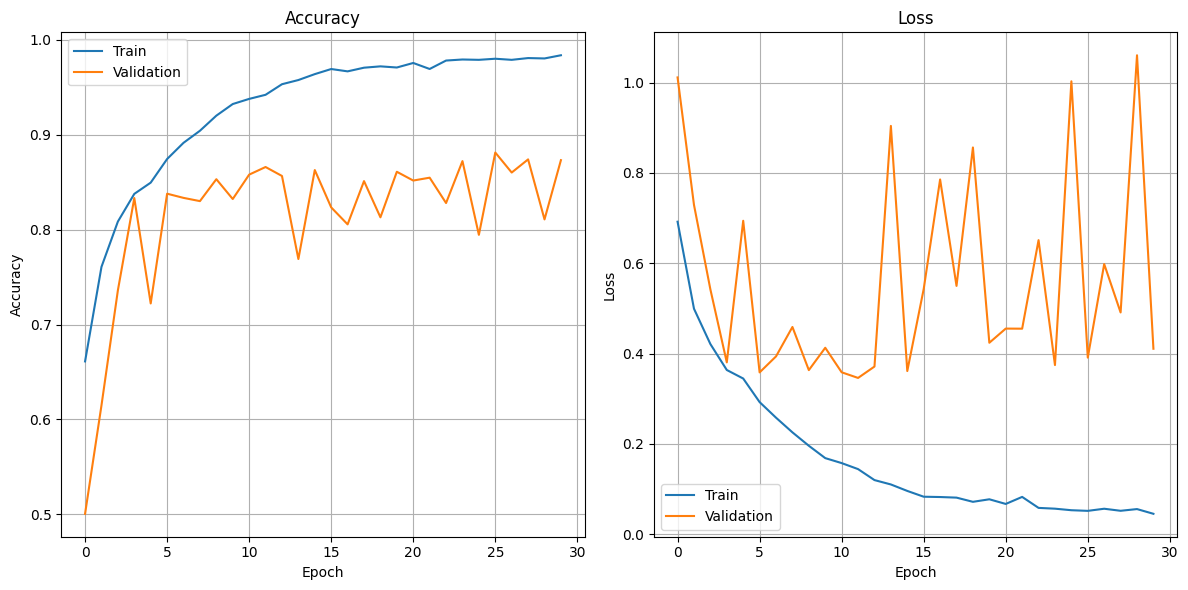

156/156 [==============================] - 1s 5ms/step
Fold 2: Accuracy: 0.8692508535850573, Zero-One Loss: 0.13074914641494273, Binary Cross Entropy Loss: 0.15358950681984423


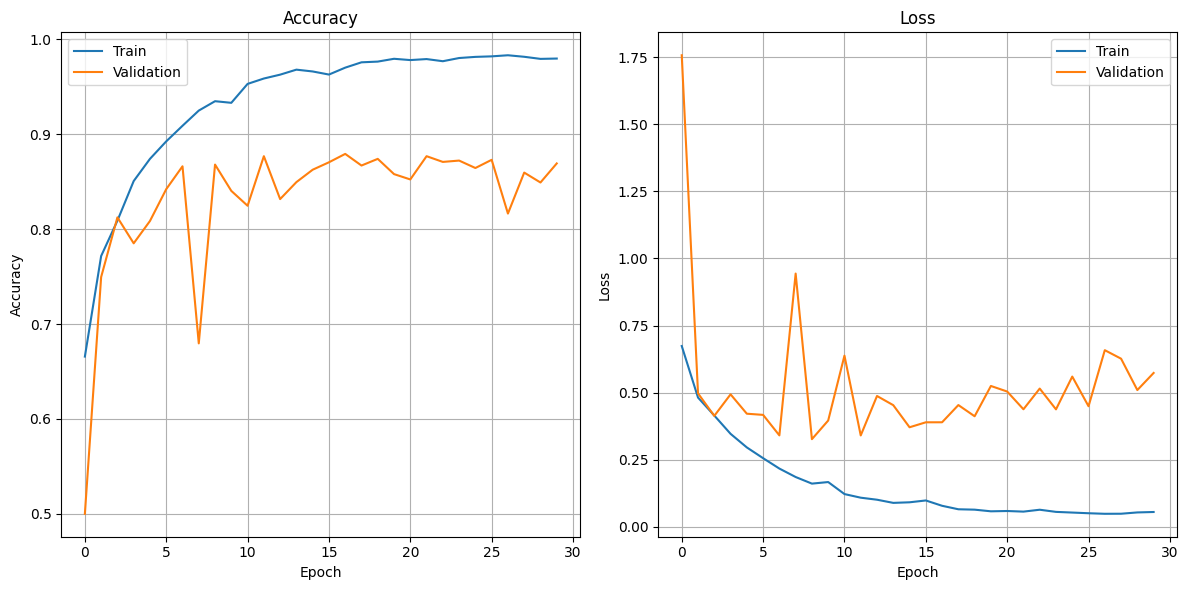

156/156 [==============================] - 1s 5ms/step
Fold 3: Accuracy: 0.870857601928098, Zero-One Loss: 0.12914239807190198, Binary Cross Entropy Loss: 0.15059319188197454


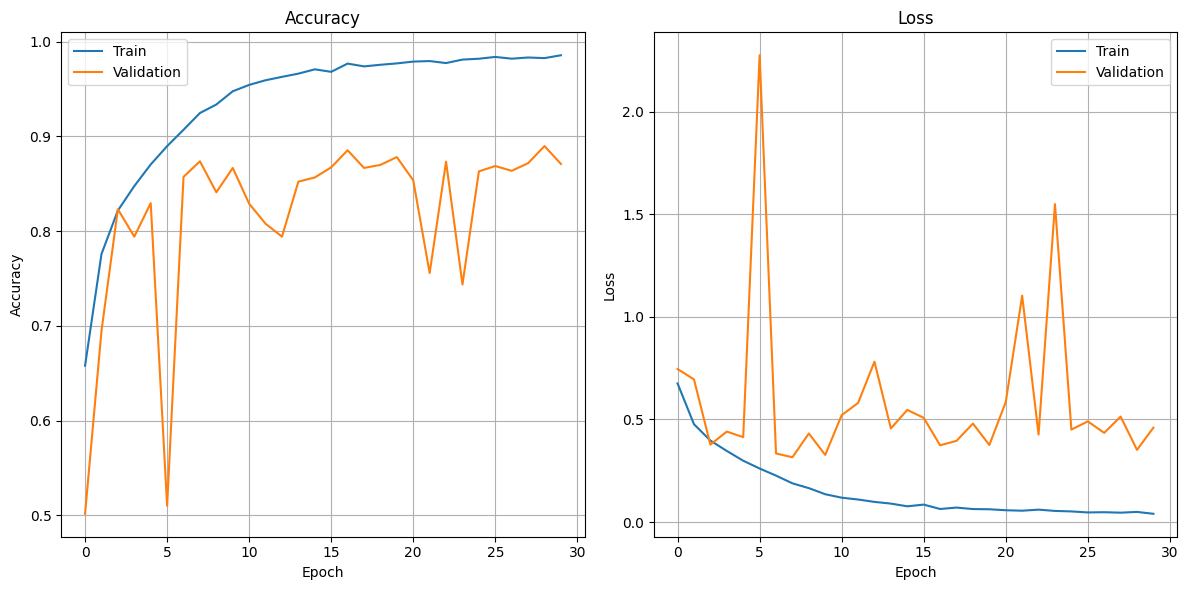

156/156 [==============================] - 1s 5ms/step
Fold 4: Accuracy: 0.8662382004418558, Zero-One Loss: 0.13376179955814416, Binary Cross Entropy Loss: 0.14986042194068433


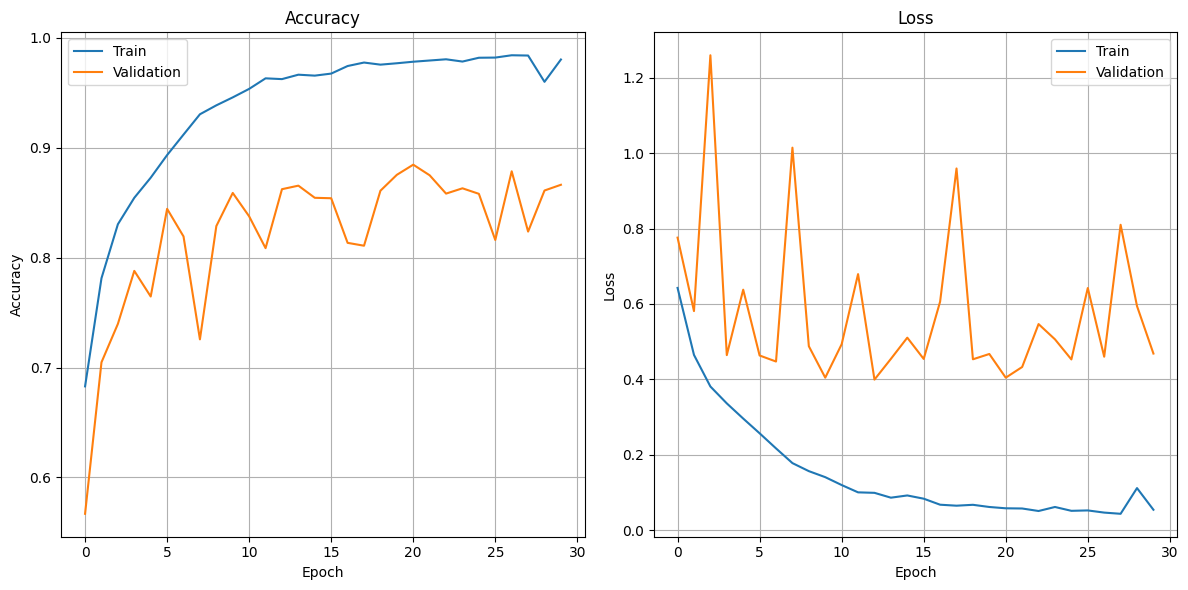

156/156 [==============================] - 1s 5ms/step
Fold 5: Accuracy: 0.8345049206668006, Zero-One Loss: 0.1654950793331994, Binary Cross Entropy Loss: 0.16378019005060196


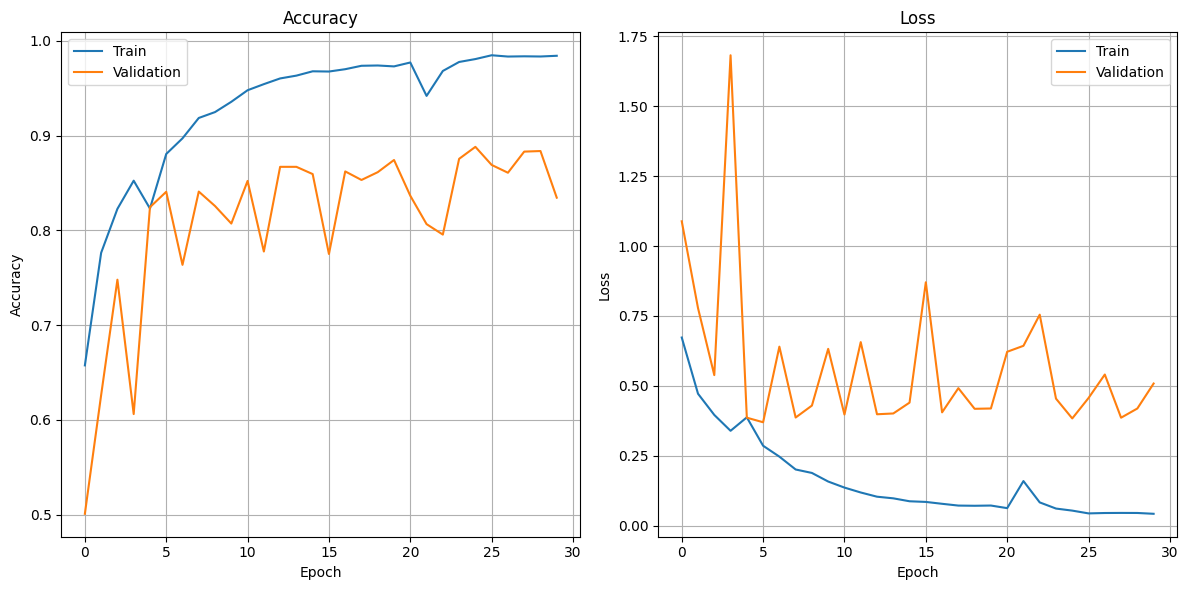

Average Accuracy: 0.8628238602128941
Average Zero-One Loss: 0.1371761397871058
Average Binary Cross Entropy Loss: 0.1573248779773712


In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
import numpy as np

def create_model():
    model = Sequential()

    # First convolutional layer
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Second convolutional layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Third convolutional layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Flattening the tensor output from the convolutional layers
    model.add(Flatten())

    # Dense layer
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    return model

# Initialize 5-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True)

# Lists to store the scores, zero-one loss, and binary cross entropy loss for each fold
scores_per_fold = []
zero_one_losses = []
binary_cross_entropy_losses = []

# Perform 5-fold CV, print results, and calculate metrics for each fold
for fold, (train_index, test_index) in enumerate(kfold.split(images_grey, labels_grey)):
    # Split data into training and test set
    train_images, test_images = images_grey[train_index], images_grey[test_index]
    train_labels, test_labels = labels_grey[train_index], labels_grey[test_index]

    model = create_model()

    # Train the model
    history = model.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=30, batch_size=64, verbose=0)

    # Use the model to make predictions on the test set
    predictions = model.predict(test_images)
    predictions = np.round(predictions).flatten()

    # Compute accuracy and zero-one loss
    score = accuracy_score(test_labels, predictions)
    zero_one_loss = 1 - score

    scores_per_fold.append(score)
    zero_one_losses.append(zero_one_loss)
    binary_cross_entropy_loss = np.mean(history.history['loss'])
    binary_cross_entropy_losses.append(binary_cross_entropy_loss)

    print(f"Fold {fold+1}: Accuracy: {score}, Zero-One Loss: {zero_one_loss}, Binary Cross Entropy Loss: {binary_cross_entropy_loss}")

    # Plot accuracy and loss for current fold
    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Compute the average scores
avg_score = np.mean(scores_per_fold)
avg_zero_one_loss = np.mean(zero_one_losses)
avg_binary_cross_entropy_loss = np.mean(binary_cross_entropy_losses)

print(f"Average Accuracy: {avg_score}")
print(f"Average Zero-One Loss: {avg_zero_one_loss}")
print(f"Average Binary Cross Entropy Loss: {avg_binary_cross_entropy_loss}")
    